Just like in the previous chapter, let's define the default font sizes to make the figures prettier:

In [85]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [86]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [87]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

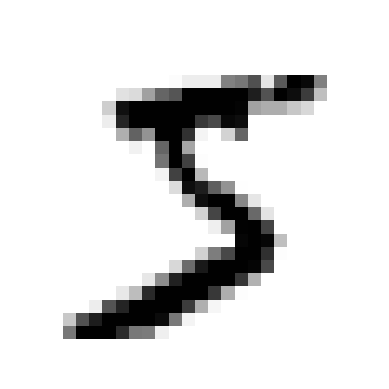

In [88]:
# Show array as image
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

# Create the training and test datasets

**Exercise**

Write a function that can rotate an MNIST image in any direction (left, right, up,
or down). Then, for each image in the training set, create four
rotated copies(one per direction) and add them to the training set. Finally, train
your best model on this expanded training set and measure its accuracy on the
test set. You should observe that your model performs even better now! This
technique of artificially growing the training set is called data augmentation or
training set expansion.

In [89]:
threshold = 10000 # 60000 is default
X_train_initial, X_test, y_train_initial, y_test = X[:threshold], X[threshold:], y[:threshold], y[threshold:]

In [90]:
import numpy as np

shuffle_index = np.random.permutation(threshold)

X_train_shuffled, y_train_shuffled = X_train_initial[shuffle_index], y_train_initial[shuffle_index]
X_train_shuffled

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(10000, 784))

## Rotating images to see if it's better at predicting

In [91]:
def rotate_flattened_images_x4(array, image_shape=(28, 28)):
    new_array = []
    for item in array:
        img = item.reshape(image_shape)
        new_array.append(img.flatten())
        new_array.append(np.rot90(img, 1).flatten())
        new_array.append(np.rot90(img, 2).flatten())
        new_array.append(np.rot90(img, 3).flatten())
    return np.array(new_array)

# Repeats the same label 4 times to fit with the multiple versions of the image
def repeat_labels_x4(labels):
    return np.repeat(labels, 4)

X_train_rotated = rotate_flattened_images_x4(X_train_shuffled)
y_train_rotated = repeat_labels_x4(y_train_shuffled)

len(X_train_rotated)

40000

### Random forest

In [92]:
y_train_5_rotated = (y_train_rotated == '5')
y_train_5_initial = (y_train_initial == '5')

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest_rotated = cross_val_predict(forest_clf, X_train_rotated, y_train_5_rotated, cv=3,
                                    method="predict_proba")
y_probas_forest_rotated[:2]

array([[0.9 , 0.1 ],
       [0.92, 0.08]])

In [94]:
y_probas_forest_initial = cross_val_predict(forest_clf, X_train_initial, y_train_5_initial, cv=3,
                                    method="predict_proba")
y_probas_forest_initial[:2]

array([[0.3 , 0.7 ],
       [0.99, 0.01]])

#### Precision/recall curve

In [95]:
from sklearn.metrics import precision_recall_curve

y_scores_forest_rotated = y_probas_forest_rotated[:, 1]
precisions_forest_rotated, recalls_forest_rotated, thresholds_forest_rotated = precision_recall_curve(
    y_train_5_rotated, y_scores_forest_rotated)

y_scores_forest_initial = y_probas_forest_initial[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5_initial, y_scores_forest_initial)

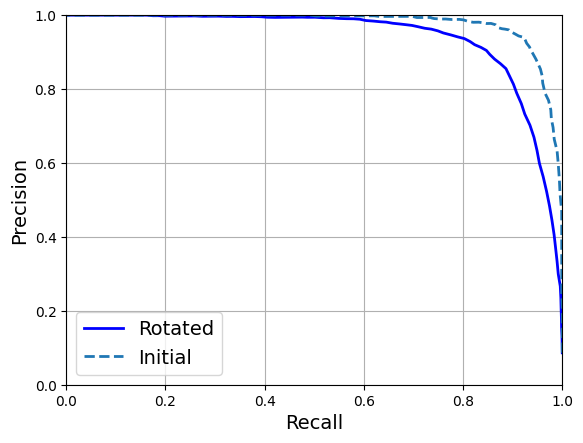

In [96]:
plt.plot(recalls_forest_rotated, precisions_forest_rotated, "b-", linewidth=2,
         label="Rotated")
plt.plot(recalls_forest, precisions_forest, "--", linewidth=2,
         label="Initial")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

#### Confusion matrix

In [97]:
from sklearn.metrics import confusion_matrix

y_train_pred_rotated = cross_val_predict(forest_clf, X_train_rotated, y_train_5_rotated, cv=3)

cm_rotated = confusion_matrix(y_train_5_rotated, y_train_pred_rotated)
cm_rotated

array([[36529,    19],
       [ 1503,  1949]])

> NOTE: Very few FP (false positives) since it's only 19, but almost half FN (false negatives) with 1503.

In [98]:
y_train_pred_initial = cross_val_predict(forest_clf, X_train_initial, y_train_5_initial, cv=3)

cm_initial = confusion_matrix(y_train_5_initial, y_train_pred_initial)
cm_initial

array([[9132,    5],
       [ 227,  636]])

## Shifting instead of rotating

Exercise: Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_.

In [99]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

def shift_images_x5(array, pixels=1):
    shifted = []
    for image in array:
        shifted.append(image)
        shifted.append(shift_image(image, pixels, 0))    # right
        shifted.append(shift_image(image, -pixels, 0))   # left
        shifted.append(shift_image(image, 0, pixels))    # down
        shifted.append(shift_image(image, 0, -pixels))   # up
    return shifted

X_train_shifted = shift_images_x5(X_train_initial)

def repeat_labels_x5(labels):
    return np.repeat(labels, 5)

y_train_shifted = repeat_labels_x5(y_train_initial)


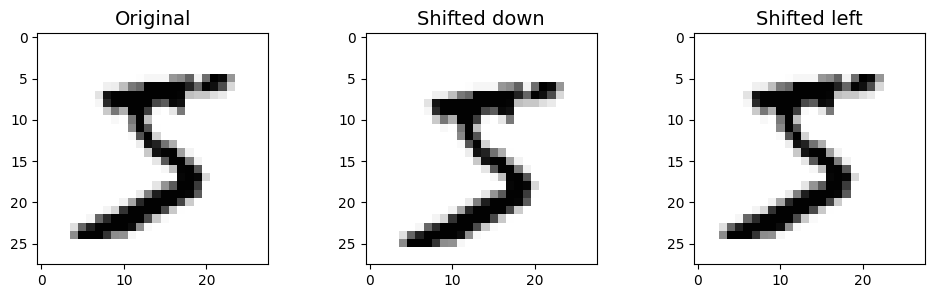

In [100]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(X_train_shifted[0].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(X_train_shifted[3].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(X_train_shifted[2].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [101]:
y_train_5_shifted = (y_train_shifted == '5')

y_probas_forest_shifted = cross_val_predict(forest_clf, X_train_shifted, y_train_5_shifted, cv=3,
                                    method="predict_proba")
y_probas_forest_shifted[:2]

y_scores_forest_shifted = y_probas_forest_shifted[:, 1]
precisions_forest_shifted, recalls_forest_shifted, thresholds_forest_shifted = precision_recall_curve(
    y_train_5_shifted, y_scores_forest_shifted)

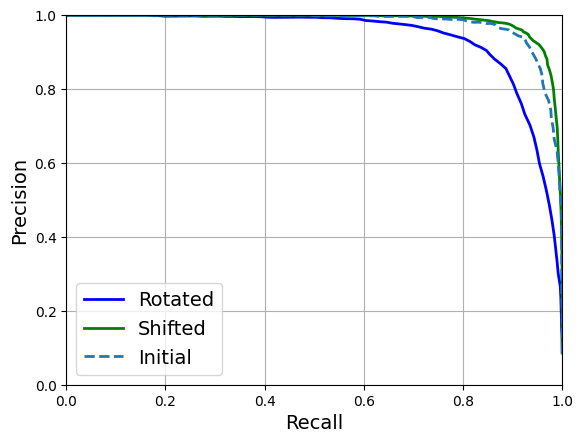

In [102]:
plt.plot(recalls_forest_rotated, precisions_forest_rotated, "b-", linewidth=2,
         label="Rotated")
plt.plot(recalls_forest_shifted, precisions_forest_shifted, "g-", linewidth=2,
         label="Shifted")
plt.plot(recalls_forest, precisions_forest, "--", linewidth=2,
         label="Initial")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

## Shifting x pixels

Trying with different numbers of pixels

In [103]:
X_train_shifted_5 = shift_images_x5(X_train_initial, pixels=5)

y_train_shifted_5 = repeat_labels_x5(y_train_initial)

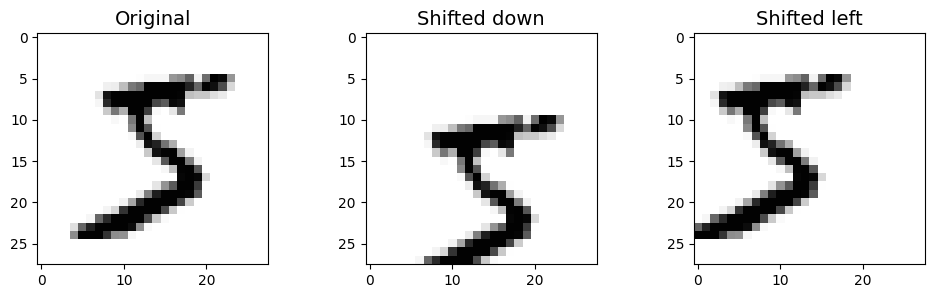

In [104]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(X_train_shifted_5[0].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(X_train_shifted_5[3].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(X_train_shifted_5[2].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [105]:
y_train_5_shifted_5 = (y_train_shifted == '5')

y_probas_forest_shifted_5 = cross_val_predict(forest_clf, X_train_shifted_5, y_train_5_shifted_5, cv=3,
                                    method="predict_proba")
y_probas_forest_shifted_5[:2]

y_scores_forest_shifted_5 = y_probas_forest_shifted_5[:, 1]
precisions_forest_shifted_5, recalls_forest_shifted_5, thresholds_forest_shifted_5 = precision_recall_curve(
    y_train_5_shifted_5, y_scores_forest_shifted_5)

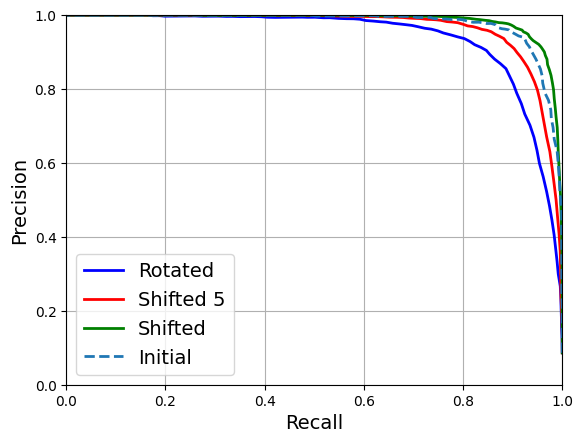

In [106]:
plt.plot(recalls_forest_rotated, precisions_forest_rotated, "b-", linewidth=2,
         label="Rotated")
plt.plot(recalls_forest_shifted_5, precisions_forest_shifted_5, "r-", linewidth=2,
         label="Shifted 5")
plt.plot(recalls_forest_shifted, precisions_forest_shifted, "g-", linewidth=2,
         label="Shifted")
plt.plot(recalls_forest, precisions_forest, "--", linewidth=2,
         label="Initial")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

### Shifting 2 pixels

In [107]:
X_train_shifted_2 = shift_images_x5(X_train_initial, pixels=2)

y_train_shifted_2 = repeat_labels_x5(y_train_initial)

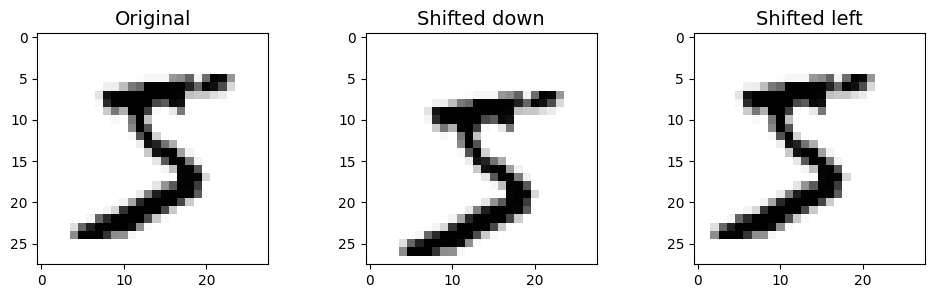

In [108]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(X_train_shifted_2[0].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(X_train_shifted_2[3].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(X_train_shifted_2[2].reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [109]:
y_train_5_shifted_2 = (y_train_shifted == '5')

y_probas_forest_shifted_2 = cross_val_predict(forest_clf, X_train_shifted_2, y_train_5_shifted_2, cv=3,
                                    method="predict_proba")
y_probas_forest_shifted_2[:2]

y_scores_forest_shifted_2 = y_probas_forest_shifted_2[:, 1]
precisions_forest_shifted_2, recalls_forest_shifted_2, thresholds_forest_shifted_2 = precision_recall_curve(
    y_train_5_shifted_2, y_scores_forest_shifted_2)

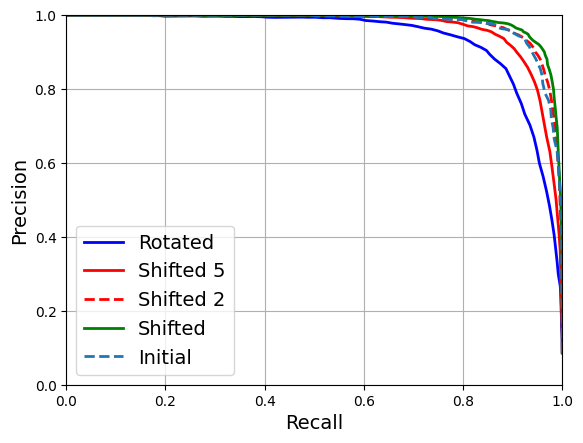

In [110]:
plt.plot(recalls_forest_rotated, precisions_forest_rotated, "b-", linewidth=2,
         label="Rotated")
plt.plot(recalls_forest_shifted_5, precisions_forest_shifted_5, "r-", linewidth=2,
         label="Shifted 5")
plt.plot(recalls_forest_shifted_2, precisions_forest_shifted_2, "r--", linewidth=2,
         label="Shifted 2")
plt.plot(recalls_forest_shifted, precisions_forest_shifted, "g-", linewidth=2,
         label="Shifted")
plt.plot(recalls_forest, precisions_forest, "--", linewidth=2,
         label="Initial")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

## Next step (from feedback)

Big chance of overfitting when we suddenly have 5x the initial images where all look very alike. To prevent overfitting we should put less epochs to run through - some kind of early stopping - and checking with validation set to see if it's actually any better.